Install dependencies [colab]

In [1]:
! pip install torchtext==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 991.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.5 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


mount drive [colab]

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Preparing Data

Define the data fields and the necessary tokenization required. A basic word based tokenizer is configured

In [3]:
from torchtext.data.utils import get_tokenizer
import torch
from torchtext.data import Field, LabelField, TabularDataset, BucketIterator
#from torchtext import datasets

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = Field(tokenize = get_tokenizer('basic_english'), include_lengths = True)
LABEL = LabelField(dtype = torch.float)

Create train and test data splits from Phase 1 preprocessed data.

In [4]:
train_data, test_data = TabularDataset.splits(
  path="/content/gdrive/MyDrive/DIC/",
  train='train.csv',
  test='test.csv',
  format='csv',
  fields=[('review', TEXT), ('label', LABEL)])

We can see how many examples are in each split by checking their length.

In [5]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')
print(vars(train_data.examples[0]))

Number of training examples: 10000
Number of testing examples: 200
{'review': ['product', 'arrived', 'labeled', 'as', 'jumbo', 'salted', 'peanuts', 'the', 'peanuts', 'were', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'if', 'this', 'was', 'an', 'error', 'or', 'if', 'the', 'vendor', 'intended', 'to', 'represent', 'the', 'product', 'as', 'jumbo'], 'label': '0'}


The IMDb dataset only has train/test splits, so we need to create a validation set. We can do this with the `.split()` method.

By default this splits 70/30, however by passing a `split_ratio` argument, we can change the ratio of the split, i.e. a `split_ratio` of 0.8 would mean 80% of the examples make up the training set and 20% make up the validation set.

We also pass our random seed to the `random_state` argument, ensuring that we get the same train/validation split each time.

Next is the use of pre-trained word embeddings. Now, instead of having our word embeddings initialized randomly, they are initialized with these pre-trained vectors. Here, we will use max vocab size of top 25000 most common words for quick training.

We get these vectors simply by specifying which vectors we want and passing it as an argument to `build_vocab`. `TorchText` handles downloading the vectors and associating them with the correct words in our vocabulary.

Here, we'll be using the `"fasttext.simple.300d" vectors"`. `300d` indicates these vectors are 100-dimensional.

You can see the other available vectors [here](https://github.com/pytorch/text/blob/master/torchtext/vocab.py#L113).

The theory is that these pre-trained vectors already have words with similar semantic meaning close together in vector space, e.g. "terrible", "awful", "dreadful" are nearby. This gives our embedding layer a good initialization as it does not have to learn these relations from scratch.

**Note**: these vectors are about 293MB, so watch out if you have a limited internet connection.

By default, TorchText will initialize words in your vocabulary but not in your pre-trained embeddings to zero. We don't want this, and instead initialize them randomly by setting `unk_init` to `torch.Tensor.normal_`. This will now initialize those words via a Gaussian distribution. This initialization is for the words which appear in the examples but we have cut from the vocabulary. For example, if the sentence was "This film is great and I love it" but the word "love" was not in the vocabulary, it would become "This film is great and I `<unk>` it".

Splice train data into 80% train and 20% validation splits

In [6]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED), split_ratio=0.8)

Build vocaublary and assign pretrained fasttext embeddings to vectorize the word tokens

In [7]:
# MAX_VOCAB_SIZE = 10_000

TEXT.build_vocab(train_data,
                #  max_size = MAX_VOCAB_SIZE,
                 vectors = "fasttext.simple.300d",
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

.vector_cache/wiki.simple.vec: 293MB [00:02, 133MB/s]                           
100%|██████████| 111051/111051 [00:16<00:00, 6728.91it/s]


Unique tokens in TEXT and LABEL vocabulary.


In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 17632
Unique tokens in LABEL vocabulary: 2


Most common vocabulary items

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 27711), ('i', 24841), ('and', 17671), ('a', 15474), ('it', 14625), ('to', 14220), ('is', 13571), ('of', 11075), ('not', 10077), ('this', 9811), ('in', 7346), ('for', 7178), ('that', 6489), ('have', 6048), ('my', 6047), ('was', 5594), ('but', 5293), ('with', 4901), ('are', 4765), ('you', 4643)]


Defining the data iterators for batch processing and the GPU

In [9]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("We are working with ", device)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.review),
    sort_within_batch = True,
    device = device)

We are working with  cuda


Bidirectional Multi-Layer LSTM




Define the LSTM recurrent neural network with a linear network head for classification.

Includes \
Embedding layer \
LSTM layer \
Feed forward layer \
dropout for regularization \
non-linear tanh activation

In [10]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers,
                 bidirectional, dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size,embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=hidden_dim,num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim*2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.directions=1
        if bidirectional:
          self.directions=2
        self.hidden_size = hidden_dim

    def forward(self, text, text_lengths):

        batch = text.shape[1]
        emb = self.embedding(text)

        #packed = nn.utils.rnn.pack_padded_sequence(emb, text_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed = emb
        _, (hidden, _) = self.lstm(packed)
        hidden = hidden.view(-1, self.directions, batch, self.hidden_size)
        hidden = hidden.sum(0)
        if self.directions == 2:
          hidden = torch.cat([hidden[-2,:,:],hidden[-1,:,:]], -1)
        hidden = torch.tanh(self.dropout(hidden))
        return self.fc(hidden.view(-1, batch, self.hidden_size*2 if self.directions==2 else self.hidden_size))

Define hyperparameters

In [24]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTM(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            OUTPUT_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

Number of trainable parameters

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,009,857 trainable parameters


copying the pretrained word embeddings into the embedding layer and assigning zero tensors for special characters like unknown and pad tokens

In [26]:
pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)

torch.Size([17632, 300])


In [27]:
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ..., -1.4447,  0.8402, -0.8668],
        [ 0.1032, -1.6268,  0.5729,  ...,  0.3180, -0.1626, -0.0417],
        [ 0.0104, -0.1829,  0.0761,  ..., -0.1362, -0.2240, -0.0552],
        ...,
        [-1.8520, -0.6486,  0.5383,  ..., -0.2914, -0.6109, -0.4139],
        [-2.5351,  0.7111,  0.8984,  ..., -1.2381,  0.3214,  0.2492],
        [ 2.0848,  0.2470,  0.0064,  ..., -0.3049,  0.0578, -1.4032]])

In [28]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0104, -0.1829,  0.0761,  ..., -0.1362, -0.2240, -0.0552],
        ...,
        [-1.8520, -0.6486,  0.5383,  ..., -0.2914, -0.6109, -0.4139],
        [-2.5351,  0.7111,  0.8984,  ..., -1.2381,  0.3214,  0.2492],
        [ 2.0848,  0.2470,  0.0064,  ..., -0.3049,  0.0578, -1.4032]])


## Train the Model

Defining the optimizer

In [29]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

Defining the Binary Cross Entropy los function objeective for the binary classification task

In [30]:
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

define the accuracy estimation function

In [31]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

Training routine

In [32]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.review

        predictions = model(text, text_lengths).squeeze()

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Validation routine

In [33]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:

            text, text_lengths = batch.review

            predictions = model(text, text_lengths).squeeze()

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()



    return epoch_loss / len(iterator), epoch_acc / len(iterator)

Define a function to compute time of the epochs

In [34]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Training loop and saving the best performing model

In [35]:
N_EPOCHS = 5
path = F"/content/gdrive/My Drive/DIC/bilstm_model_v1.pt"
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), path)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.584 | Train Acc: 68.81%
	 Val. Loss: 0.497 |  Val. Acc: 76.90%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.401 | Train Acc: 82.46%
	 Val. Loss: 0.387 |  Val. Acc: 85.30%
Epoch: 03 | Epoch Time: 0m 5s
	Train Loss: 0.381 | Train Acc: 83.44%
	 Val. Loss: 0.538 |  Val. Acc: 76.66%
Epoch: 04 | Epoch Time: 0m 5s
	Train Loss: 0.274 | Train Acc: 89.70%
	 Val. Loss: 0.413 |  Val. Acc: 81.79%
Epoch: 05 | Epoch Time: 0m 5s
	Train Loss: 0.194 | Train Acc: 92.74%
	 Val. Loss: 0.484 |  Val. Acc: 86.13%


Test accuracy

In [36]:
model.load_state_dict(torch.load(path, map_location=device))

test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.357 | Test Acc: 88.67%


Define the pipeline for inference

Includes

Tokenization \
length \
predtiction

In [37]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [48]:
import pandas as pd

test_sentences = pd.read_csv("/content/gdrive/MyDrive/DIC/test.csv", names=["reviews","labels"])
sentences = list(test_sentences["reviews"])
labels = list(test_sentences["labels"])

In [53]:
preds = []
for x in sentences:
  preds.append(int(predict_sentiment(model,x) < 0.5))

Confusion Matrix

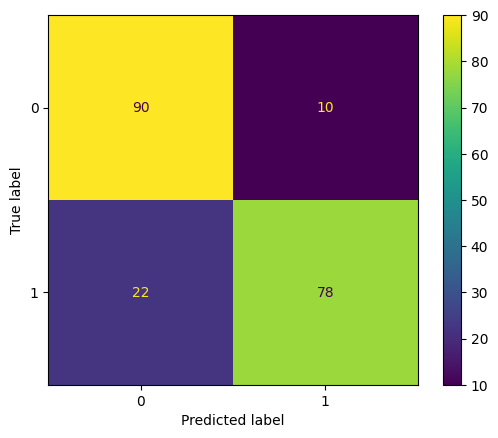

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=[0,1])
disp.plot()